# Data Exploration

### Import libraries.

In [1]:
import os
import sys
import tarfile
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import h5py
from collections import Counter
from six.moves.urllib.request import urlretrieve
from six.moves import cPickle as pickle
from IPython.display import display, Image
from scipy import ndimage

# Config the matplotlib backend as plotting inline in IPython
%matplotlib inline

### Download datasets.

In [2]:
url = 'http://ufldl.stanford.edu/housenumbers/'
last_percent_reported = None
data_root = '.' # Change me to store data elsewhere

def download_progress_hook(count, blockSize, totalSize):
  """A hook to report the progress of a download. This is mostly intended for users with
  slow internet connections. Reports every 5% change in download progress.
  """
  global last_percent_reported
  percent = int(count * blockSize * 100 / totalSize)

  if last_percent_reported != percent:
    if percent % 5 == 0:
      sys.stdout.write("%s%%" % percent)
      sys.stdout.flush()
    else:
      sys.stdout.write(".")
      sys.stdout.flush()
      
    last_percent_reported = percent
        
def maybe_download(filename, expected_bytes, force=False):
  """Download a file if not present, and make sure it's the right size."""
  dest_filename = os.path.join(data_root, filename)
  if force or not os.path.exists(dest_filename):
    print('Attempting to download:', filename) 
    filename, _ = urlretrieve(url + filename, dest_filename, reporthook=download_progress_hook)
    print('\nDownload Complete!')
  statinfo = os.stat(dest_filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified', dest_filename)
  else:
    raise Exception(
      'Failed to verify ' + dest_filename + '. Can you get to it with a browser?')
  return dest_filename

In [3]:
train_filename = maybe_download('train.tar.gz', 404141560)
test_filename = maybe_download('test.tar.gz', 276555967)
extra_filename = maybe_download('extra.tar.gz',1955489752)
#maybe_download('train_32x32.mat', 182040794)
#maybe_download('test_32x32.mat', 64275384)
#maybe_download('extra_32x32.mat', 1329278602)

('Found and verified', './train.tar.gz')
('Found and verified', './test.tar.gz')
('Found and verified', './extra.tar.gz')


### Extract data.

In [4]:
def maybe_extract(filename, force=False):
  root = os.path.splitext(os.path.splitext(filename)[0])[0]  # remove .tar.gz
  if os.path.isdir(root) and not force:
    # You may override by setting force=True.
    print('%s already present - Skipping extraction of %s.' % (root, filename))
  else:
    print('Extracting data for %s. This may take a while. Please wait.' % root)
    tar = tarfile.open(filename)
    sys.stdout.flush()
    tar.extractall(data_root)
    tar.close()
    print('Extracting done.')
  return 
  
maybe_extract(train_filename, force=False)
maybe_extract(test_filename, force=False)
maybe_extract(extra_filename, force=False)

./train already present - Skipping extraction of ./train.tar.gz.
./test already present - Skipping extraction of ./test.tar.gz.
./extra already present - Skipping extraction of ./extra.tar.gz.


### Function for extracting metadata.

In [5]:
def get_attr(f, i, attr):
    d = f[f['/digitStruct/bbox'][i][0]][attr].value.squeeze()
    if d.dtype == 'float64':
        return d.reshape(-1)
    return np.array([f[x].value for x in d]).squeeze()

def load_metadata(path):
    f = h5py.File(path,"r")

    metadata={}
    metadata['image']=[]
    metadata['length']=[]
    metadata['label']=[]
    metadata['width']=[]
    metadata['height']=[]
    metadata['top']=[]
    metadata['left']=[]

    imageLength=f['/digitStruct/name'].shape[0]
    for i in range(imageLength):
        refName=f['/digitStruct/name'][i][0]
        name = f[refName].value.tostring().replace('\x00', '')
        
        labels=get_attr(f,i,'label')
        # replace label of digit '0' which is initially labeled '10'
        for j in range(len(labels)):
            if (labels[j]==10):
                labels[j]=0
        
        width=get_attr(f,i,'width')
        height=get_attr(f,i,'height')
        top=get_attr(f,i,'top')
        left=get_attr(f,i,'left')
        
        metadata['image'].append(name)
        metadata['label'].append(labels)
        metadata['length'].append(len(labels))
        metadata['width'].append(width)
        metadata['height'].append(height)
        metadata['top'].append(top)
        metadata['left'].append(left)

        if (i % 5000 == 0):
            print('%s elapsed.'% i)
    return metadata

def maybe_extract_and_pickle_metadata(index=0, force=False):
    if (index == 0):
        path = './train/digitStruct.mat'
        filename = 'train_metadata'
    elif (index == 1):
        path = './test/digitStruct.mat'
        filename = 'test_metadata'
    elif (index == 2):
        path = './extra/digitStruct.mat'
        filename = 'extra_metadata'
        
    if os.path.exists(filename + '.pickle') and not force:
        # You may override by setting force=True.
        print('%s already present - Skipping extracting. Loading pickle file instead.' % (filename + '.pickle'))
        try:
            print('Loading %s ...' % (filename + '.pickle'))
            with open(filename + '.pickle', 'rb') as f:
                metadata = pickle.load(f)
            print('Loading done.')
        except Exception as e:
            metadata = -1
            print('Unable to process data from', filename, ':', e)
    else:
        print('Extracting metadata %s ...' % path )
        metadata = load_metadata(path)
        print('Extracting done.')
        print('Pickling %s ...' % (filename + '.pickle'))
        try:
            with open(filename + '.pickle', 'wb') as f:
                pickle.dump(metadata, f, pickle.HIGHEST_PROTOCOL)
        except Exception as e:
            print('Unable to save data to',  filename + '.pickle', ':', e)
        print('Pickling done.')
  
    return metadata

In [6]:
train_metadata = maybe_extract_and_pickle_metadata(index=0, force=False)
test_metadata = maybe_extract_and_pickle_metadata(index=1, force=False)
extra_metadata = maybe_extract_and_pickle_metadata(index=2, force=False)

train_metadata.pickle already present - Skipping extracting. Loading pickle file instead.
Loading train_metadata.pickle ...
Loading done.
test_metadata.pickle already present - Skipping extracting. Loading pickle file instead.
Loading test_metadata.pickle ...
Loading done.
extra_metadata.pickle already present - Skipping extracting. Loading pickle file instead.
Loading extra_metadata.pickle ...
Loading done.


### Utility functions for exploratory visualization

In [7]:
def display_basic_stats(index=0):
    if (index == 0):
        print("Basic statistics of train data:")
        metadata = train_metadata
        image_path = './train/'
    elif (index == 1):
        print("Basic statistics of test data:")
        metadata = test_metadata
        image_path = './test/'
    elif (index == 2):
        print("Basic statistics of extra data:")
        metadata = extra_metadata
        image_path = './extra/'
    print('Number of sample: %s' % len(metadata['image']))
    print('Min length of sequence: %s' % min(metadata['length']))
    print('Max length of sequence: %s' % max(metadata['length']))
    print('Dimension of first 10 images:')
    for i in range(10):
        image_file=metadata['image'][i]
        img = mpimg.imread(os.path.join(image_path, image_file))
        print('%s x %s' % (img.shape[1],img.shape[0]))

In [8]:
def display_first_ten_images(index = 0):
    if (index == 0):
        title = "First 10 images of train dataset"
        metadata = train_metadata
        image_path = './train/'
    elif (index == 1):
        title = "First 10 images of test dataset"
        metadata = test_metadata
        image_path = './test/'
    elif (index == 2):
        title = "First 10 images of extra dataset"
        metadata = extra_metadata
        image_path = './extra/'
    fig = plt.figure(figsize=(14, 6))
    plt.title(title)
    plt.axis("off")
    rows = 2
    columns = 5
    for i in range(rows*columns):
        image_file=metadata['image'][i]
        image_label=metadata['label'][i]
        label_string = ""
        for j in range(len(image_label)):
            label_string+=str(int(image_label[j]))
        img = mpimg.imread(os.path.join(image_path, image_file))
        fig.add_subplot(rows, columns, i+1)
        plt.title(label_string)
        plt.axis("off")
        plt.imshow(img)
    plt.tight_layout()
    plt.show()

In [9]:
def plot_length_hist(data,max_freq,title):
    label_chars=['1','2','3','4','5']
    tickLocations = np.arange(len(label_chars))

    fig, ax = plt.subplots(figsize=(3, 3.5))
    n, bins, patches = plt.hist(data-1, bins=range(0,12), align='left')
    ax.set_xticks(ticks= tickLocations)
    ax.set_xticklabels(label_chars)
    plt.axis([-1,5,0,max_freq])
    plt.title(title)
    plt.ylabel("Frequency")
    plt.xlabel("Digit sequence length")
    plt.show()

### Exploratory visualization for train dataset

In [10]:
display_basic_stats(index=0)

Basic statistics of train data:
Number of sample: 33402
Min length of sequence: 1
Max length of sequence: 6
Dimension of first 10 images:
741 x 350
199 x 83
52 x 23
161 x 79
140 x 68
74 x 35
99 x 54
54 x 22
79 x 34
74 x 37


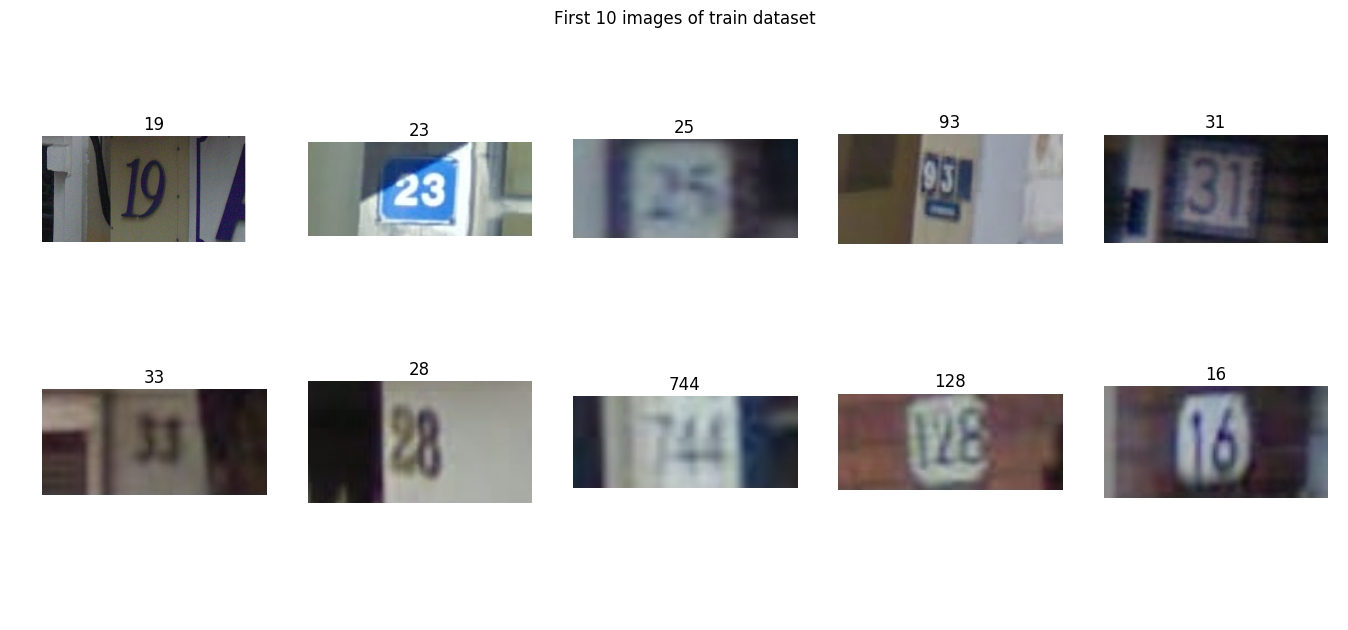

In [11]:
display_first_ten_images(index=0)

In [12]:
print(Counter(train_metadata['length']))

Counter({2: 18130, 3: 8691, 1: 5137, 4: 1434, 5: 9, 6: 1})


In [13]:
training_length = np.array(train_metadata['length'])
print(np.argwhere(training_length==6))

[[29929]]


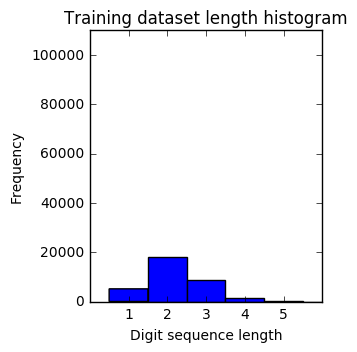

In [14]:
training_length_5_digit=np.delete(training_length,29929)   
plot_length_hist(training_length_5_digit,110000,"Training dataset length histogram")

In [15]:
print(training_length_5_digit.shape)
print(Counter(training_length_5_digit))

(33401,)
Counter({2: 18130, 3: 8691, 1: 5137, 4: 1434, 5: 9})


### Exploratory visualization for test dataset

In [16]:
display_basic_stats(index=1)

Basic statistics of test data:
Number of sample: 13068
Min length of sequence: 1
Max length of sequence: 5
Dimension of first 10 images:
99 x 47
182 x 48
101 x 31
75 x 31
215 x 81
94 x 43
99 x 38
133 x 62
94 x 31
87 x 55


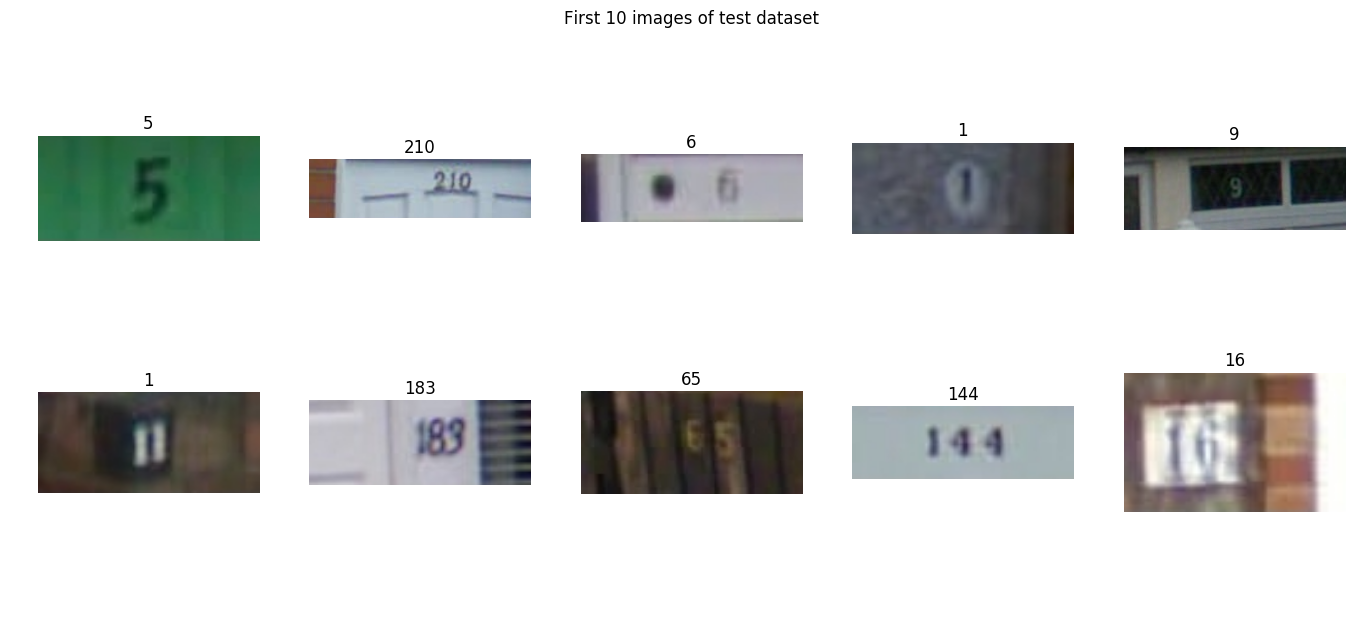

In [17]:
display_first_ten_images(index=1)

In [18]:
print(Counter(test_metadata['length']))

Counter({2: 8356, 1: 2483, 3: 2081, 4: 146, 5: 2})


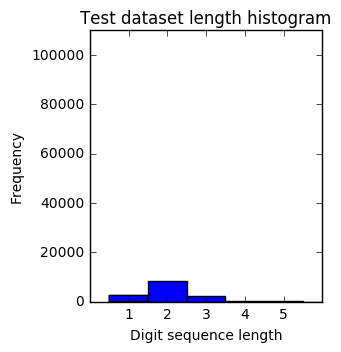

In [19]:
plot_length_hist(np.array(test_metadata['length']),110000,"Test dataset length histogram")

In [20]:
print(len(test_metadata['length']))
print(Counter(test_metadata['length']))

13068
Counter({2: 8356, 1: 2483, 3: 2081, 4: 146, 5: 2})


### Exploratory visualization for extra dataset

In [21]:
display_basic_stats(index=2)

Basic statistics of extra data:
Number of sample: 202353
Min length of sequence: 1
Max length of sequence: 5
Dimension of first 10 images:
166 x 141
295 x 261
137 x 96
79 x 50
81 x 50
90 x 44
63 x 44
88 x 54
47 x 43
52 x 41


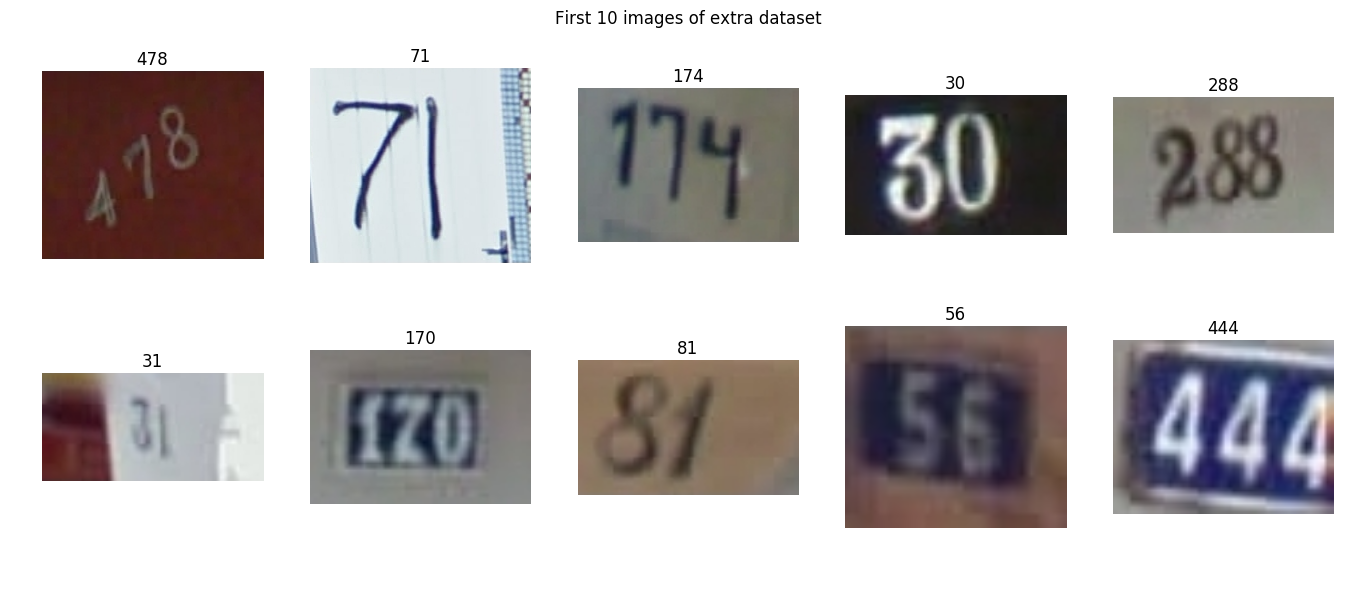

In [22]:
display_first_ten_images(index=2)

In [23]:
print(Counter(extra_metadata['length']))

Counter({3: 106789, 2: 71726, 4: 14338, 1: 9385, 5: 115})


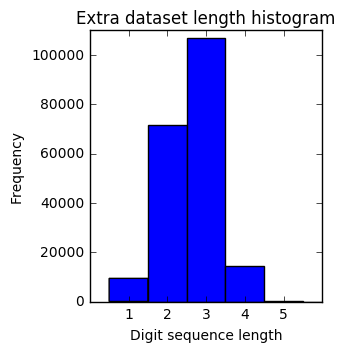

In [24]:
plot_length_hist(np.array(extra_metadata['length']),110000,"Extra dataset length histogram")

In [25]:
print(len(extra_metadata['length']))
print(Counter(extra_metadata['length']))

202353
Counter({3: 106789, 2: 71726, 4: 14338, 1: 9385, 5: 115})
